### Import Libraries

In [1]:
import pandas as pd
import pathlib
from joblib import load

import sys
sys.path.append("../utils")
from split_utils import get_features_data
from train_utils import get_dataset
from evaluate_utils import model_F1_score

### Load Necessary Data

In [2]:
# load features data from indexes and features dataframe
data_split_path = pathlib.Path("../1.split_data/indexes/data_split_indexes.tsv")
data_split_indexes = pd.read_csv(data_split_path, sep="\t", index_col=0)
features_dataframe_path = pathlib.Path("../0.download_data/data/training_data.csv.gz")
features_dataframe = get_features_data(features_dataframe_path)

### Evaluate Each Model on Each Dataset

Evaluating model on dataset test


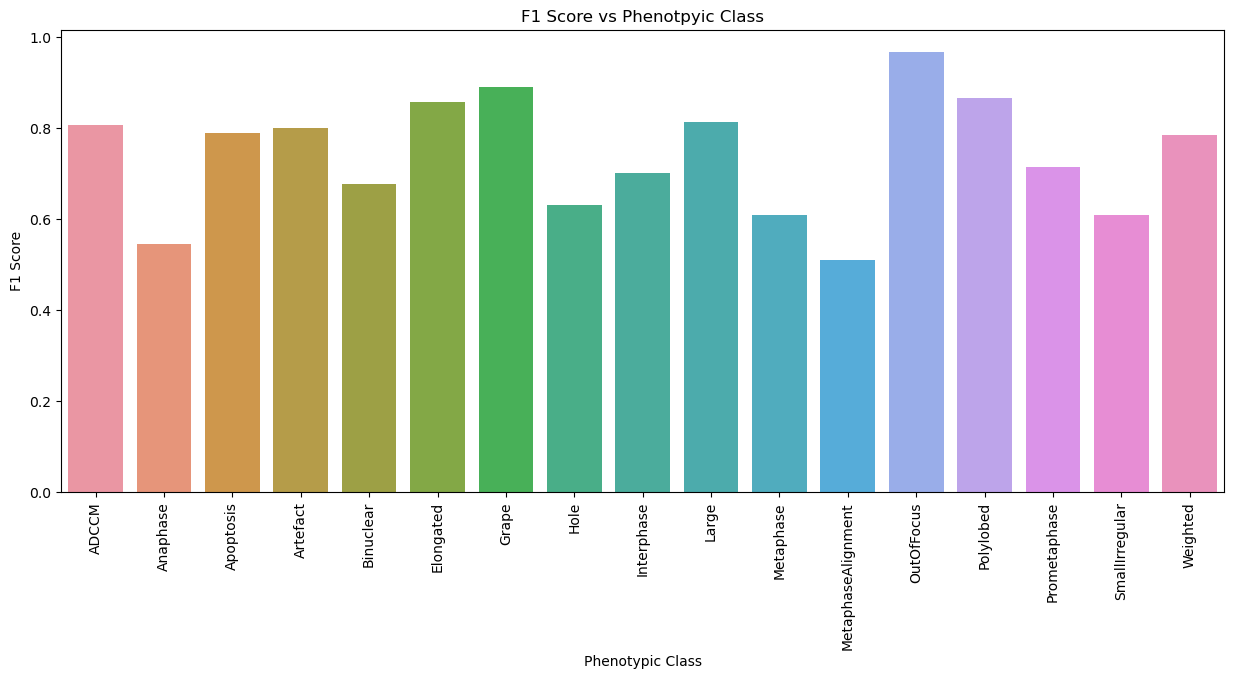

Evaluating model on dataset train


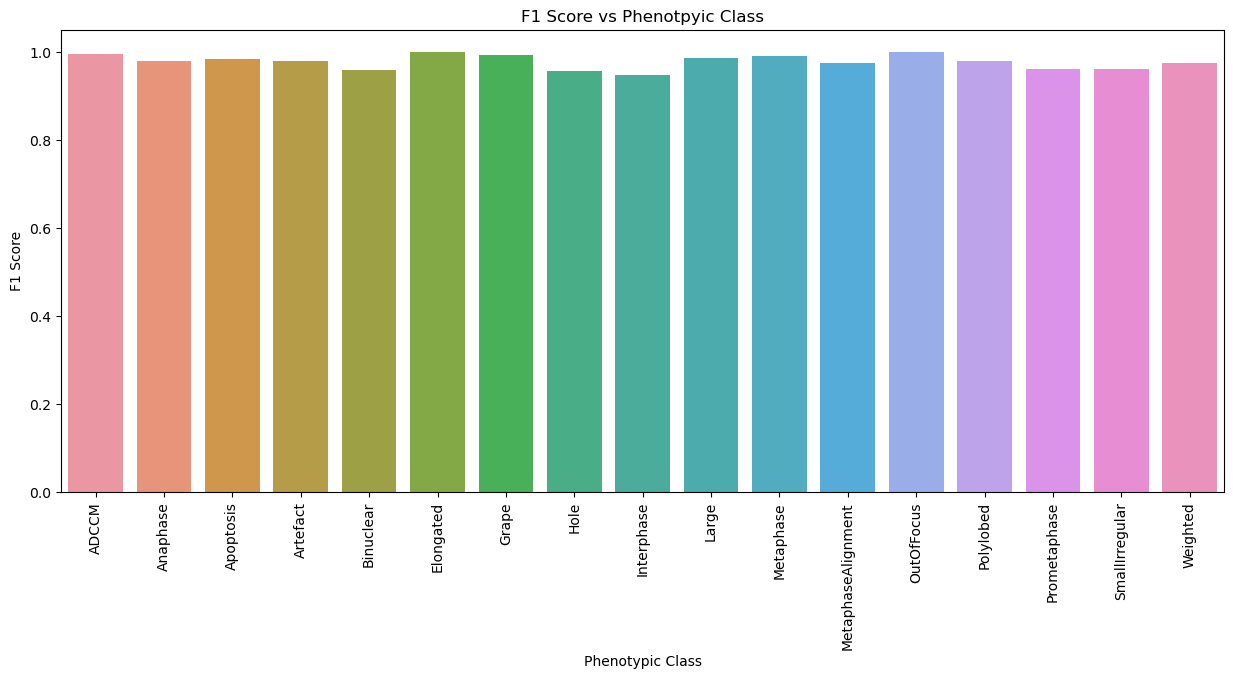

Evaluating shuffled_baseline_model on dataset test


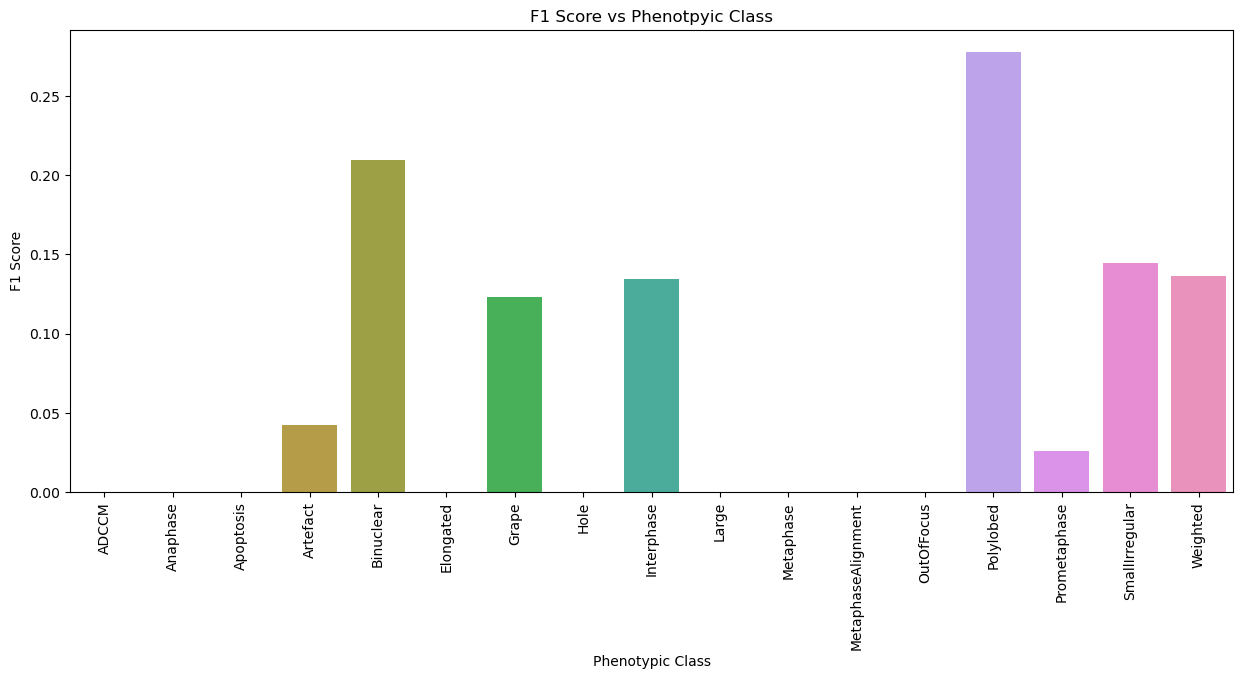

Evaluating shuffled_baseline_model on dataset train


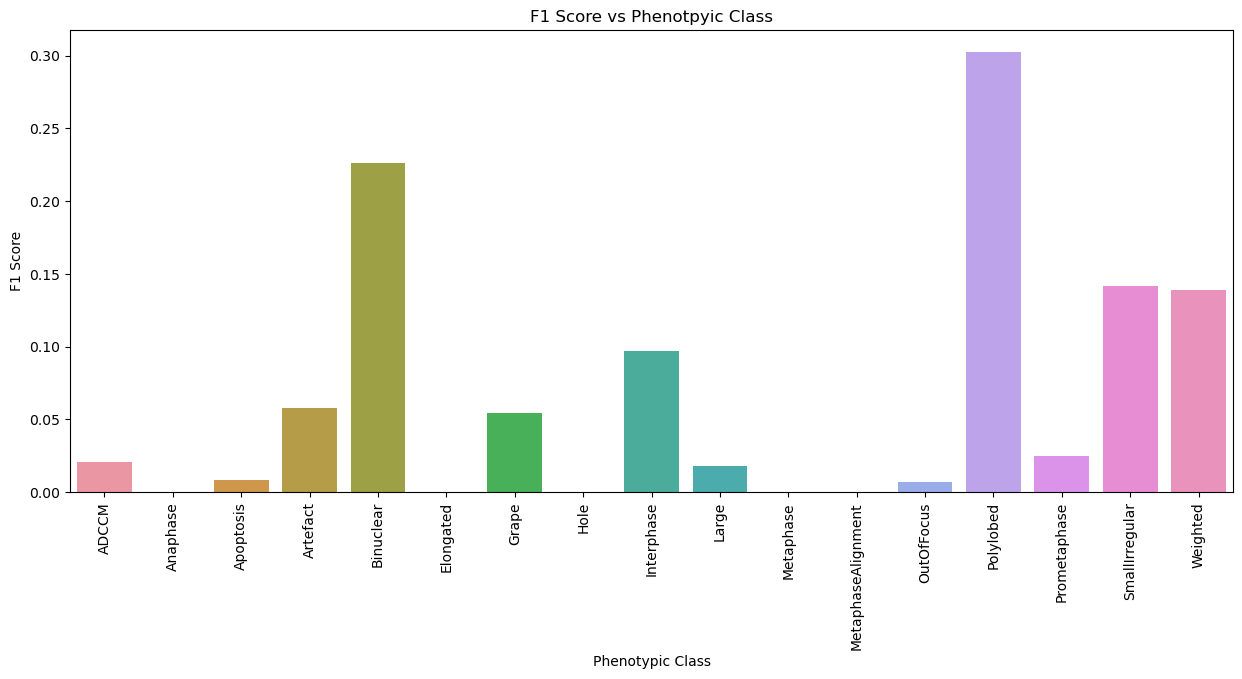

In [3]:
# directory to load the models from
models_dir = pathlib.Path("../2.train_model/models/")

# use a list to keep track of scores in tidy long format for each model and dataset combination
tidy_scores = []

# iterate through each model (final model, shuffled baseline model, etc)
for model_path in models_dir.iterdir():
    model = load(model_path)
    model_name = model_path.name.replace("log_reg_","").replace(".joblib","")
    
    # iterate through label datasets (labels correspond to train, test, etc)
    # with nested for loops, we test each model on each dataset(corresponding to a label)
    for label in data_split_indexes["label"].unique():
        print(f"Evaluating {model_name} on dataset {label}")
        
        # load dataset (train, test, etc)
        data = get_dataset(features_dataframe, data_split_indexes, label)
        # find model F1 scores on dataset
        score = model_F1_score(model, data)
        
        # add score data to compiled dataframe in tidy format
        # transpose data and reset index to make dataframe resemble tidy long format
        score = score.T.reset_index()
        # change columns to their respective names
        score.columns = ["Phenotypic_Class", "F1_Score"]
        # add data split column to indicate which dataset scores are from (train, test, etc)
        score["data_split"] = label
        # add shuffled column to indicate if the model has been trained with shuffled data (random baseline) or not
        score["shuffled"] = True if "shuffled" in model_name else False
        # add this score data to the tidy scores compiling list
        tidy_scores.append(score)

### Save scores from each evaluation

In [4]:
# compile list of tidy data into one dataframe
tidy_scores = pd.concat(tidy_scores).reset_index(drop=True)

# specify results directory
f1_scores_dir = pathlib.Path("evaluations/F1_scores/")
f1_scores_dir.mkdir(parents=True, exist_ok=True)

# define save path
tidy_scores_save_path = pathlib.Path(f"{f1_scores_dir}/compiled_F1_scores.tsv")

# save data as tsv
tidy_scores.to_csv(tidy_scores_save_path, sep="\t")

# preview tidy data
tidy_scores

,Phenotypic_Class,F1_Score,data_split,shuffled
0,ADCCM,0.807692,test,False
1,Anaphase,0.545455,test,False
2,Apoptosis,0.788991,test,False
3,Artefact,0.800000,test,False
4,Binuclear,0.677083,test,False
...,...,...,...,...
63,OutOfFocus,0.006873,train,True
64,Polylobed,0.302488,train,True
65,Prometaphase,0.024510,train,True
66,SmallIrregular,0.141361,train,True
